In [1]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\10784\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\10784\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\10784\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

SUMMARY_PATH = 'MutualFundSummary'
SUMMARY_LABELS_PATH = 'MutualFundLabels.csv'
glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

In [3]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [4]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)

In [11]:
#Preprocess the texts
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa','ab'])

In [9]:
# clean and tokenize the text
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = lemma_tokenizer(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

In [12]:
text_words = np.concatenate([tokenizer(summary) for summary in summaries])
print(text_words[:20])

['market' 'income' 'portfolio' 'investment' 'objective' 'fund'
 'investment' 'objective' 'seek' 'current' 'income' 'consideration'
 'capital' 'appreciation' 'fee' 'expense' 'fund' 'table' 'describes' 'fee']


In [13]:
#Process Skip-Gram model Input
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3072


In [14]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

print(data[:20])

[8, 30, 10, 3, 91, 1, 3, 91, 129, 168, 30, 1204, 76, 538, 14, 9, 1, 51, 310, 14]


In [15]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [16]:
#Train the skip-gram model
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

# We create the model
encoder, autoencoder = creat_word2vec_model()

In [17]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 50)                153650    
                                                                 
 dense_1 (Dense)             (None, 3072)              156672    
                                                                 
Total params: 310,322
Trainable params: 310,322
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

<ipython-input-18-872bc948d3d9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


Epoch 1/2
7448/7448 [==============================] - 61s 8ms/step - loss: 0.0126
Epoch 2/2
7448/7448 [==============================] - 58s 8ms/step - loss: 0.0023


In [19]:
#Use the encoder to vectorize
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec)

In [23]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

words_neighbors_1 = get_n_closer('expense', 10, word2vec)
print('words close to expense : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('derivative', 10, word2vec)
print('words close to derivative : ' +str(', '.join(words_neighbors_2)))

words close to expense : expense, operating, total, table, annual, following, example, reflected, describes, expenses1
words close to derivative : derivative, instrument, enforce, real, relative, lending, unsponsored, growth-oriented, relation, often


In [24]:
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(3072, 50)


E:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
E:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(3072, 2)


In [25]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

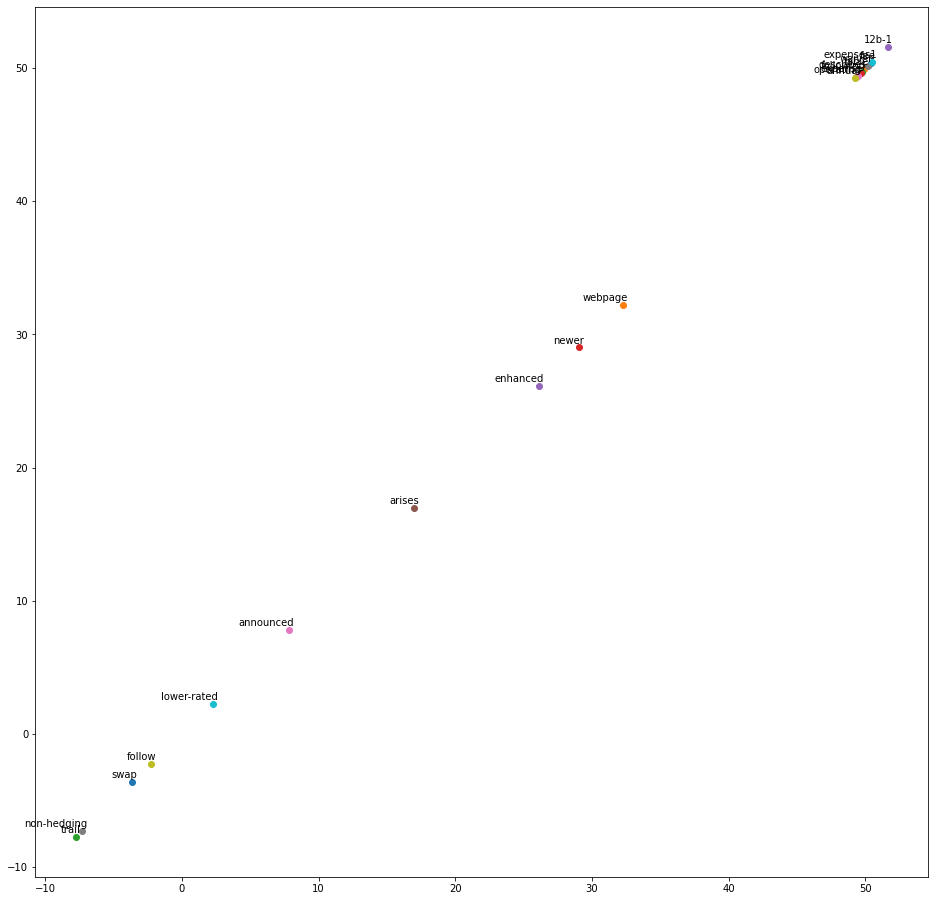

In [27]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])
    
    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['fee', 'swap'], 10, word2vec)

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

In [33]:
key_words = ['balance', 'fund', 'risk', 'low', 'high', 'equity', 'bond', 'income', 'long', 'short', 'commodity', 'loan', 'hedged', 'cash']

In [34]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [35]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base = create_knowledge_base(10, word2vec, key_words)

In [36]:
print(knowledge_base)

{'find', 'including', 'began', 'gain', 'international', 'accrual', 'six-month', 'tax-qualified', 'analyzing', 'sometimes', 'distribute', 'intended', 'rising', 'junk', 'line', 'reed', 'rent', 'perform', 'feature', 'inflation-protected', 'represents', 'sector', 'exchange-rate', 'focus', 'associated', 'paper', 'bond', 'try', 'historical', 'statutory', 'whole', 'help', 'finance', 'book', 'indicator', 'resemble', 'drs', 'smallest', 'utility', 'dividend', 'concentrated', 'important', 'valuation', 'income', 'poorly', 'equity', 'mandated', 'europe', 'maturity', 'california', 'japan', 'extreme', 'commodity', 'consumer', 'allocated', 'condition', 'region', 'cap', 'measure', 'capital', 'managing', 'hedged', 'focused', 'fail', 'right', 'august', 'although', 'accounting', 'compare', 'generally', 'undervalued', 'slump', 'fund', 'exposed', 'description', 'processed', 'incurred', 'major', 'main', 'kingdom', 'current', 'appropriate', 'close', 'positive', 'owned', 'dependent', 'meaning', 'exempt', 'long

In [111]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [112]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [113]:
df['deriv_sentences_distance'] = df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [114]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [115]:
df['deriv_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

In [116]:
X = df['deriv_sentences_distance'].values
# X = df['deriv_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'anticipated merger consummated april however series reserve right delay closing merger investing fut'

In [117]:
print(df['Ivestment Strategy'].unique())
print(df['Ivestment Strategy'])

['Balanced Fund (Low Risk)' 'Fixed Income Long Only (Low Risk)'
 'Equity Long Only (Low Risk)' 'Long Short Funds (High Risk)']
0               Balanced Fund (Low Risk)
1               Balanced Fund (Low Risk)
2               Balanced Fund (Low Risk)
3               Balanced Fund (Low Risk)
4               Balanced Fund (Low Risk)
                     ...                
461    Fixed Income Long Only (Low Risk)
462    Fixed Income Long Only (Low Risk)
463          Equity Long Only (Low Risk)
464          Equity Long Only (Low Risk)
465          Equity Long Only (Low Risk)
Name: Ivestment Strategy, Length: 465, dtype: object


In [119]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(df['Ivestment Strategy']),y=df['Ivestment Strategy'])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.3839285714285714,
 1: 0.4706477732793522,
 2: 0.8942307692307693,
 3: 29.0625}

In [118]:
y=np.array(pd.get_dummies(df['Ivestment Strategy']))
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

E:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\anaconda\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

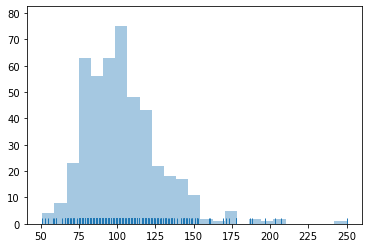

In [121]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

In [128]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 100 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

word2vec_g = load_word2vec(glove_word2vec)

# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : furthermore smaller company often limited product line operating history market and/or financial resource may dependent one key person management susceptible loss investor farther retirement risk fund may invest much investment designed ensure capital conservation current income may prevent investor meeting retirement goal investing future delivery contract underlying fund may enter contract to-be-announced contract mortgage dollar roll involve underlying fund selling mortgage-related security simultaneously contracting repurchase similar security delivery future date predetermined price example often difficult value dispose small company stock difficult obtain information smaller company larger company msci® country world ex usa index represents portion equity security outside u.s. certain underlying fund may invest
Index sequences : [459, 159, 4, 202, 125, 99, 489, 228, 229, 6, 57, 58, 48, 305, 2, 306, 141, 291, 490, 25, 432, 43, 18, 863, 215, 8, 1, 2, 39, 491, 5, 126, 763, 31

In [129]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [130]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 109
length of the paded first sequence : 100


In [131]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    #embedding_vector = word2vec_g.get(word)
    embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [132]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(4, activation='sigmoid'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [135]:
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, y_train, epochs=100, batch_size=4, validation_data=(feature_test, y_test),class_weight=class_weights)

Epoch 1/100
93/93 [==============================] - 9s 40ms/step - loss: 1.2509 - accuracy: 0.2285 - val_loss: 1.2529 - val_accuracy: 0.1398
Epoch 2/100
93/93 [==============================] - 2s 23ms/step - loss: 1.1893 - accuracy: 0.3360 - val_loss: 1.1847 - val_accuracy: 0.4946
Epoch 3/100
93/93 [==============================] - 2s 23ms/step - loss: 1.1156 - accuracy: 0.2742 - val_loss: 1.2278 - val_accuracy: 0.1935
Epoch 4/100
93/93 [==============================] - 2s 23ms/step - loss: 1.1211 - accuracy: 0.2957 - val_loss: 1.2105 - val_accuracy: 0.5484
Epoch 5/100
93/93 [==============================] - 2s 22ms/step - loss: 1.0786 - accuracy: 0.3790 - val_loss: 1.2621 - val_accuracy: 0.2688
Epoch 6/100
93/93 [==============================] - 2s 23ms/step - loss: 1.0852 - accuracy: 0.4140 - val_loss: 1.2543 - val_accuracy: 0.4194
Epoch 7/100
93/93 [==============================] - 2s 22ms/step - loss: 1.0890 - accuracy: 0.2769 - val_loss: 1.2345 - val_accuracy: 0.5269
Epoch 

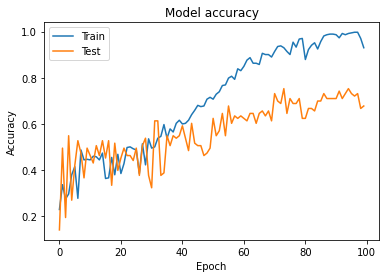

In [136]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

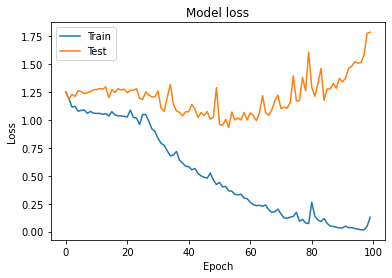

In [137]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [138]:
y_pred_RNN = RNN_model.predict(feature_test)
score = RNN_model.evaluate(feature_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
results = [np.argmax(y_pred_RNN[i]) for i in range(len(y_pred_RNN))]

Test loss: 1.7848471403121948
Test accuracy: 0.6774193644523621


In [139]:
results

[0,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 2]